In [2]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `~/Projects/BIASlab/ThesisParallelMP`


In [131]:
using RxInfer, Random, StatsPlots, BenchmarkTools, LinearAlgebra, Profile, PProf, DrWatson

In [55]:
@show Threads.nthreads(), Threads.nthreads(:interactive)

(Threads.nthreads(), Threads.nthreads(:interactive)) = (6, 6)


(6, 6)

In [56]:
includet("../parallel.jl")

In [57]:
n = 1000  # Number of coin flips
p = 0.75 # Bias of a coin

distribution = Bernoulli(p)
dataset      = float.(rand(Bernoulli(p), n))
prior = Beta(2.0, 6.0)

Beta{Float64}(α=2.0, β=6.0)

In [58]:
@model function coin_model(n, prior, prod_strategy, pipeline, meta)

    y = datavar(Float64, n)
	θ = randomvar() where { prod_strategy = prod_strategy, prod_constraint = nothing }

    θ ~ prior

    for i in 1:n
        y[i] ~ Bernoulli(θ) where { pipeline = pipeline, meta = meta  }
    end

end

In [66]:
struct MyCustomRule
	size::Int
end

function factorial(n)
    if n == 0 || n == 1
        return 1
    else
        return factorial(n - 1) + factorial(n - 2)
    end
end

@rule Bernoulli(:p, Marginalisation) (q_out::PointMass, meta::MyCustomRule) = begin
    @logscale -log(2)
    r = mean(q_out)
    s = factorial(meta.size) / 10^8
    return Beta(one(r) + r, 2one(r) - r + s)
end

In [18]:
using ProgressMeter

In [113]:
function execute_benchmark(f::F, n = 1000) where { F }
    
    # For the compilation
    f()

    GC.gc()
    GC.gc(true)

    times = Vector{Float64}(undef, n)
    
    for i in 1:n
        times[i] = f()
    end
    
    return times
end

execute_benchmark (generic function with 2 methods)

In [62]:
function prepare_benchmark(prod, pipeline, dataset, prior, meta; niterations = 100)
    return () -> begin 
        timing = Ref(0.0)
        current_iter = Ref(0.0)
        infer(
            model = coin_model(length(dataset), prior, prod, pipeline, meta),
            data  = (y = dataset, ),
            callbacks = (
                before_iteration = (model, iteration) -> begin 
                    current_iter[] = time_ns()
                    return false
                end,
                after_iteration = (model, iteration) -> begin 
                    current_iter[] = time_ns() - current_iter[]
                    timing[] = timing[] + current_iter[]
                    return false
                end
            ),
            iterations = niterations
        )
        return timing[]
    end
end

prepare_benchmark (generic function with 1 method)

In [114]:
function run_big_benchmark(combinations, sizes; nsamples = 10, dataset = dataset, prior = prior)
    return map(sizes) do size

        results = Dict()

        @showprogress for (key, combination) in combinations
            _b_combination = prepare_benchmark(combination[1], combination[2], dataset, prior, MyCustomRule(size))
            results[key] = execute_benchmark(_b_combination, nsamples)
        end
        
        return (size, results)
    end
end

run_big_benchmark (generic function with 4 methods)

In [125]:
combinations = [
    :sequential => (nothing, nothing),
    :parallel_fifo_prod => (CustomProdStrategy(fifo_prod), nothing),
    :parallel_fifo_prod_threadsx => (CustomProdStrategy(fifo_prod_threadsx), nothing),
    :parallel_pipeline => (nothing, ThreadsPipelineStage()),
    :parallel_ipipeline => (nothing, IThreadsPipelineStage()),
    :parallel_fifo_pipeline => (CustomProdStrategy(fifo_prod), ThreadsPipelineStage()),
    :parallel_fifo_ipipeline => (CustomProdStrategy(fifo_prod), IThreadsPipelineStage()),
]

7-element Vector{Pair{Symbol, Tuple{Any, Any}}}:
                  :sequential => (nothing, nothing)
          :parallel_fifo_prod => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), nothing)
 :parallel_fifo_prod_threadsx => (CustomProdStrategy{typeof(fifo_prod_threadsx)}(fifo_prod_threadsx), nothing)
           :parallel_pipeline => (nothing, ThreadsPipelineStage())
          :parallel_ipipeline => (nothing, IThreadsPipelineStage())
      :parallel_fifo_pipeline => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), ThreadsPipelineStage())
     :parallel_fifo_ipipeline => (CustomProdStrategy{typeof(fifo_prod)}(fifo_prod), IThreadsPipelineStage())

In [126]:
results = run_big_benchmark(combinations, 10:20);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


In [127]:
sizes = getindex.(results, 1)
benchmarks = getindex.(results, 2)
names = first.(combinations)

points = map(names) do name
    name => minimum.(getindex.(benchmarks, name))
end |> Dict

Dict{Symbol, Vector{Float64}} with 7 entries:
  :parallel_fifo_pipeline      => [9.16783e7, 1.12579e8, 8.47e7, 1.14954e8, 1.1…
  :sequential                  => [4.08504e7, 5.5857e7, 7.9877e7, 1.15563e8, 1.…
  :parallel_fifo_prod_threadsx => [3.82864e7, 4.34056e7, 4.78508e7, 5.25942e7, …
  :parallel_ipipeline          => [8.97733e7, 8.80247e7, 8.84298e7, 6.33041e7, …
  :parallel_fifo_prod          => [3.49002e7, 3.72756e7, 4.33425e7, 5.16297e7, …
  :parallel_pipeline           => [8.46659e7, 8.1297e7, 8.42529e7, 7.20958e7, 7…
  :parallel_fifo_ipipeline     => [8.59569e7, 8.28236e7, 8.96193e7, 6.92324e7, …

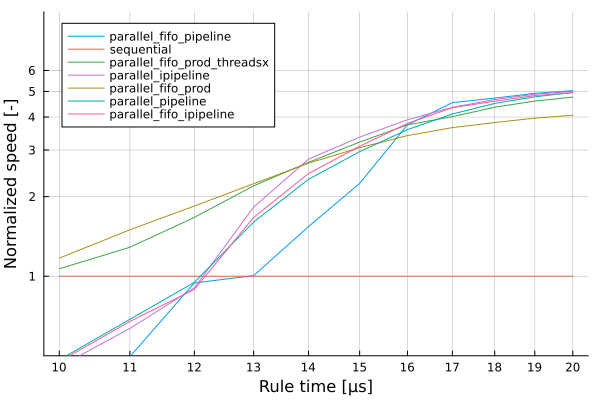

In [128]:
p = plot(
    xaxis=:log,
    yaxis=:log,
    legend=:topleft,
    xlabel="Rule time [μs]",
    ylabel="Normalized speed [-]",
    yticks=([1:Threads.nthreads(:interactive);], [string(a) for a in 1:Threads.nthreads(:interactive)]),
    xticks=(sizes, [ string(a) for a in sizes ]),
    ylim = (0.5, 10), 
    gridalpha=0.3,
)

for (key, values) in pairs(points)
    plot!(p, sizes, points[:sequential] ./ values, label = string(key))
end

p

In [77]:
using Statistics, Distributions

In [241]:
minimum(seq_times) / minimum(parallel_times)

2.703527904749914

In [229]:
minimum(seq_times) / minimum(parallel_times)

4.220078021069403

In [218]:
minimum(seq_times) / minimum(parallel_times)

2.6039856182855927

In [135]:
for i in 1:100
    infer(
        model = coin_model(length(dataset), prior, CustomProdStrategy(fifo_prod), nothing, MyCustomRule(10)),
        data  = (y = dataset, ),
    )
end

In [136]:
function run_test(prod_strategy, pipeline, size)
	rule = MyCustomRule(size)

	b = @benchmark infer(
	    model = coin_model(length($dataset), $prior, $prod_strategy, $pipeline, $rule),
	    data  = (y = $dataset, ),
	) evals=1 seconds = 20

	println("Samples: $(length(b.times))")

	return minimum(b.times)
end

run_test (generic function with 1 method)

In [137]:
# sizes = [1, 10, 60, 100]
rule_time = Vector{Float64}(undef, length(sizes))
time_s = Array{Float64}(undef, length(sizes))
time_mtp = Array{Float64}(undef, length(sizes))
time_fifo = Array{Float64}(undef, length(sizes))
time_mtp_fifo = Array{Float64}(undef, length(sizes))
time_mtp_frfo = Array{Float64}(undef, length(sizes));

In [138]:
sizes = [1, 10, 60, 100]

4-element Vector{Int64}:
   1
  10
  60
 100

In [139]:
resize!(time_s, length(sizes))
resize!(time_mtp, length(sizes))
resize!(time_fifo, length(sizes))
resize!(time_mtp_fifo, length(sizes))
resize!(time_mtp_frfo, length(sizes))
resize!(rule_time, length(sizes))

4-element Vector{Float64}:
 6.3223291396e-314
 2.2340275635e-314
 5.0e-324
 6.3223291475e-314

In [140]:
for i in eachindex(sizes)
    if true || rule_time[i] < 1e-3
        println("Evaluating coin toss model with matrix size: $(sizes[i]) and samples: $n")
        bc = @benchmark RxInfer.create_model(coin_model(length($dataset), $prior, nothing, nothing,  MyCustomRule(sizes[$i])))
        b = @benchmark @call_rule Bernoulli(:p, Marginalisation) (q_out = PointMass(1), meta = MyCustomRule(sizes[$i]))
        rule_time[i] = minimum(b.times)
        time_s[i] = run_test(nothing, nothing, sizes[i]) - minimum(bc.times)
        # time_mtp[i] = run_test(nothing, Parallel.IThreadsPipelineStage(), sizes[i]) - minimum(bc.times)
        time_fifo[i] = run_test(CustomProdStrategy(fifo_prod), nothing, sizes[i]) - minimum(bc.times)
        # time_mtp_fifo[i] = run_test(Parallel.CustomProdStrategy(Parallel.fifo_prod), Parallel.IThreadsPipelineStage(), sizes[i]) - minimum(bc.times)
        # time_mtp_frfo[i] = run_test(CustomProdStrategy(frfo_prod), IThreadsPipelineStage(), sizes[i]) - minimum(bc.times)
    end
end

Evaluating coin toss model with matrix size: 1 and samples: 1000
Samples: 5480


LoadError: Thread ids are not unique

Samples: 124


Samples: 125
Evaluating coin toss model with matrix size: 100 and samples: 1000


Samples: 9


Samples: 23

Samples: 23


Samples: 23


Samples: 23


In [110]:
rel_speed_mtp = time_s ./ time_mtp
rel_speed_fifo = time_s ./ time_fifo
rel_speed_mtp_fifo = time_s ./ time_mtp_fifo
rel_speed_mtp_frfo = time_s ./ time_mtp_frfo
rule_time_ms = rule_time / 1000;

In [111]:
rule_time_ms

4-element Vector{Float64}:
   0.12349890829694322
   2.013888888888889
  51.833
 243.792

In [112]:
rel_speed_mtp_frfo

4-element Vector{Float64}:
 0.6829606553908326
 1.1509979452944188
 4.792736186359854
 2.276949097153437

In [113]:
time_mtp_frfo

4-element Vector{Float64}:
 954667.0
      2.356542e6
      1.232025e7
      1.19512334e8

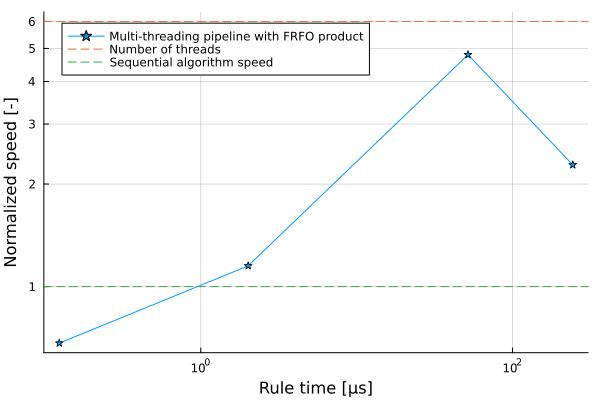

In [114]:
plot(
    xaxis=:log,
    yaxis=:log,
    legend=:topleft,
    xlabel="Rule time [μs]",
    ylabel="Normalized speed [-]",
    yticks=([1:Threads.nthreads(:interactive);], [string(a) for a in 1:Threads.nthreads(:interactive)]),
    gridalpha=0.3,
)
# plot!(rule_time_ms, rel_speed_mtp, markershape=:circle, label="Multi-threading pipeline")
# plot!(rule_time_ms, rel_speed_fifo, markershape=:rect, label="FIFO product")
# plot!(rule_time_ms, rel_speed_mtp_fifo, markershape=:rect, label="Multi-threading pipeline with FIFO product")
plot!(rule_time_ms, rel_speed_mtp_frfo, markershape=:star5, label="Multi-threading pipeline with FRFO product")
hline!([Threads.nthreads(:interactive)], linestyle=:dash, label="Number of threads")
hline!([1], linestyle=:dash, label="Sequential algorithm speed")

In [116]:
bc_i = @benchmark RxInfer.create_model(coin_model(length($dataset), $prior, nothing, nothing,  MyCustomRule(200)))

BenchmarkTools.Trial: 1700 samples with 1 evaluation.
 Range (min … max):  2.561 ms …   7.641 ms  ┊ GC (min … max): 0.00% … 62.55%
 Time  (median):     2.765 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.941 ms ± 832.718 μs  ┊ GC (mean ± σ):  5.91% ± 12.00%

   ▃█▄                                                         
  ▅████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄█▆▅▃▁▄▄▄▅▇ █
  2.56 ms      Histogram: log(frequency) by time      7.23 ms <

 Memory estimate: 3.04 MiB, allocs estimate: 90115.

In [117]:
s_i = run_test(nothing, nothing, 200) - minimum(bc_i.times)

Samples: 25


7.6713325e8

In [93]:
p_i = run_test(CustomProdStrategy(frfo_prod), IThreadsPipelineStage(), 200) - minimum(bc_i.times)

Samples: 52


3.6631375e8

In [95]:
s_i / p_i

1.9113377316576297